# Bloque 1: Librerías, carga y preparación de datos

In [ ]:
!pip install keras-tuner
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
import seaborn as sns
import matplotlib.pyplot as plt
import keras_tuner as kt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# Cargar el dataset
df = pd.read_csv("BI_dataset.csv")

# Separar columnas de entrada (X) y salida (y)
input_cols = [col for col in df.columns if col not in ['aReplica', 'Periodo', 'BI_Sistema', 'EstacionCuelloBotella'] and not col.startswith('BI_W')]
X = df[input_cols].fillna(0)
output_cols = [f'BI_W{i}' for i in range(10)]
y = df[output_cols]

# Escalar entradas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
df_test = df.loc[y_test.index, ['aReplica', 'Periodo']].reset_index(drop=True)


# Bloque 2: Tuning del modelo y tabla resumen

Trial 100 Complete [00h 00m 17s]
val_mae: 0.19865782558918

Best val_mae So Far: 0.009038373827934265
Total elapsed time: 00h 26m 17s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.5255e-04 - mae: 0.0092 

Evaluación final — MAE: 0.0090


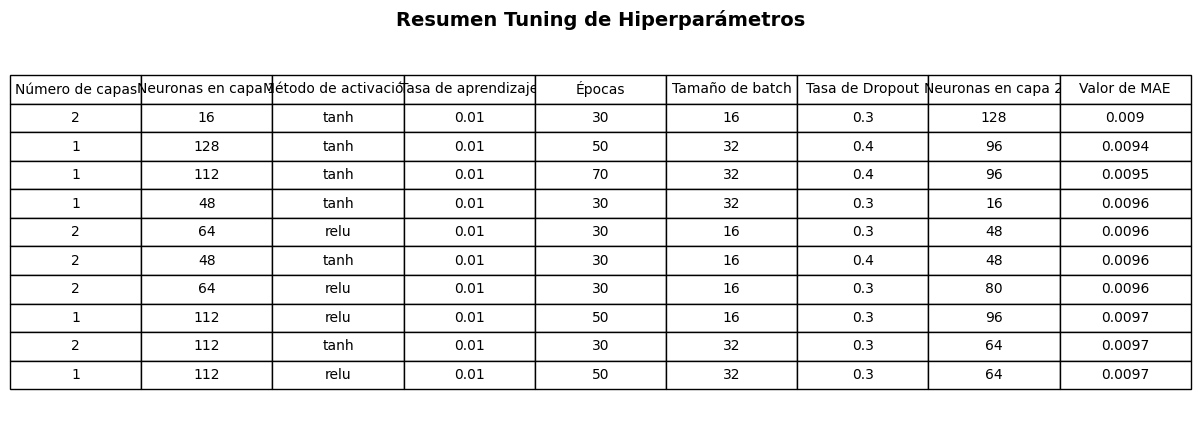

In [ ]:
# Eliminar carpeta anterior
tuning_dir = 'tuning_BI/densa_BI_model'
if os.path.exists(tuning_dir):
    shutil.rmtree(tuning_dir)

# Callback personalizado
class StopAtMae(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get("val_mae") < 0.01:
            self.model.stop_training = True

# Construcción del modelo
def build_model(hp):
    model = models.Sequential()
    model.add(layers.Input(shape=(X_train.shape[1],)))

    num_layers = hp.Int('Número de capas', 1, 2)
    for i in range(num_layers):
        model.add(layers.Dense(
            units=hp.Int(f'Neuronas en capa {i+1}', 16, 128, step=16),
            activation=hp.Choice('Método de activación', ['relu', 'tanh'])
        ))
        if hp.Boolean('usar_dropout'):
            model.add(layers.Dropout(rate=hp.Float('Tasa de Dropout', 0.1, 0.5, step=0.1)))

    model.add(layers.Dense(10))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice('Tasa de aprendizaje', [1e-2, 1e-3, 1e-4])
        ),
        loss='mse',
        metrics=['mae']
    )

    # Agregar hiperparámetros de entrenamiento
    hp.Choice('Épocas', [30, 50, 70])
    hp.Choice('Tamaño de batch', [16, 32])

    return model

# Crear tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=100,
    executions_per_trial=1,
    directory='tuning_BI',
    project_name='densa_BI_model'
)

# Ejecutar búsqueda
tuner.search(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,  # Estos se sobreescriben por los definidos en hp, pero son obligatorios aquí
    batch_size=16,
    callbacks=[StopAtMae()],
    verbose=1
)

# Evaluación
best_model = tuner.get_best_models(1)[0]
loss, mae = best_model.evaluate(X_test, y_test, verbose=1)
print(f"\nEvaluación final — MAE: {mae:.4f}")

# Resultados
trials = tuner.oracle.get_best_trials(num_trials=10)
tuning_results = []

for trial in trials:
    hp = trial.hyperparameters
    params = hp.values.copy()
    params['Épocas'] = hp.get('Épocas')
    params['Tamaño de batch'] = hp.get('Tamaño de batch')
    params['Valor de MAE'] = trial.score
    if 'usar_dropout' in params:
        del params['usar_dropout']
    tuning_results.append(params)

df_tuning = pd.DataFrame(tuning_results).sort_values(by="Valor de MAE").reset_index(drop=True)

# Visualizar tabla
plt.figure(figsize=(12, 0.5 + 0.4 * len(df_tuning)))
plt.axis('off')
tabla = plt.table(
    cellText=df_tuning.round(4).values,
    colLabels=df_tuning.columns,
    loc='center',
    cellLoc='center'
)
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1.2, 1.5)
plt.title("Resumen Tuning de Hiperparámetros", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Guardar CSV
df_tuning.to_csv("resultados_tuning_BI.csv", index=False)


# Bloque 3: Modelo con variables manuales

In [ ]:
activation = 'relu'
loss = 'mse'
metrics = ['mae']
Neuronas1 = 32
Neuronas2 = 128
learning_rate = 0.01
epochs = 70
batch_size = 16
dropout_rate = 0.1

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(Neuronas1, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(Neuronas2, activation=activation),
    layers.Dropout(dropout_rate),
    layers.Dense(10)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"\nEvaluación manual — MAE: {mae:.4f}")
model.save("modelo_final.keras")
joblib.dump(scaler, "scaler_final.pkl")

Epoch 1/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0621 - mae: 0.1633 - val_loss: 0.0064 - val_mae: 0.0527
Epoch 2/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0057 - mae: 0.0514 - val_loss: 0.0025 - val_mae: 0.0336
Epoch 3/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mae: 0.0363 - val_loss: 0.0016 - val_mae: 0.0271
Epoch 4/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018 - mae: 0.0287 - val_loss: 0.0013 - val_mae: 0.0243
Epoch 5/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - mae: 0.0245 - val_loss: 8.8469e-04 - val_mae: 0.0203
Epoch 6/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - mae: 0.0227 - val_loss: 8.8285e-04 - val_mae: 0.0196
Epoch 7/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4195e-04 - mae: 0.0213 - val_loss: 5.6476e-04 - val_mae: 0.0166
Epoch 8/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.3213e-04 - mae: 0.0194 - val_loss: 4.9127e-04 - val_mae: 0.0152
Epoch 9/70
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/st

['scaler_final.pkl']

# Bloque 4: Visualización de errores

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/tmp/ipython-input-45-1823360982.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


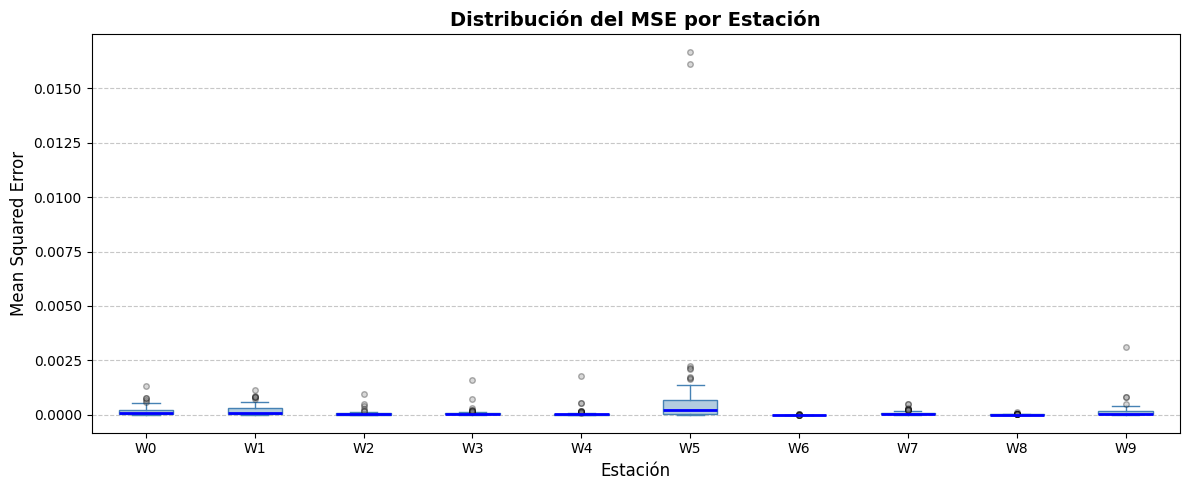

In [ ]:
y_pred_full = model.predict(X_test)

# Calcular errores cuadráticos por estación
sq_errors = np.square(y_test.values - y_pred_full)

plt.figure(figsize=(12, 5))

# Boxplot con estilo igual al MAE
box = plt.boxplot(
    sq_errors,
    patch_artist=True,
    labels=[f"W{i}" for i in range(10)],
    medianprops=dict(color='Blue', linewidth=2),
    boxprops=dict(facecolor='#b3cde0', color='#4682b4'),
    whiskerprops=dict(color='#4682b4'),
    capprops=dict(color='#4682b4'),
    flierprops=dict(markerfacecolor='gray', marker='o', markersize=4, alpha=0.3)
)

plt.title("Distribución del MSE por Estación", fontsize=14, fontweight='bold')
plt.ylabel("Mean Squared Error", fontsize=12)
plt.xlabel("Estación", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/tmp/ipython-input-46-3617401991.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(


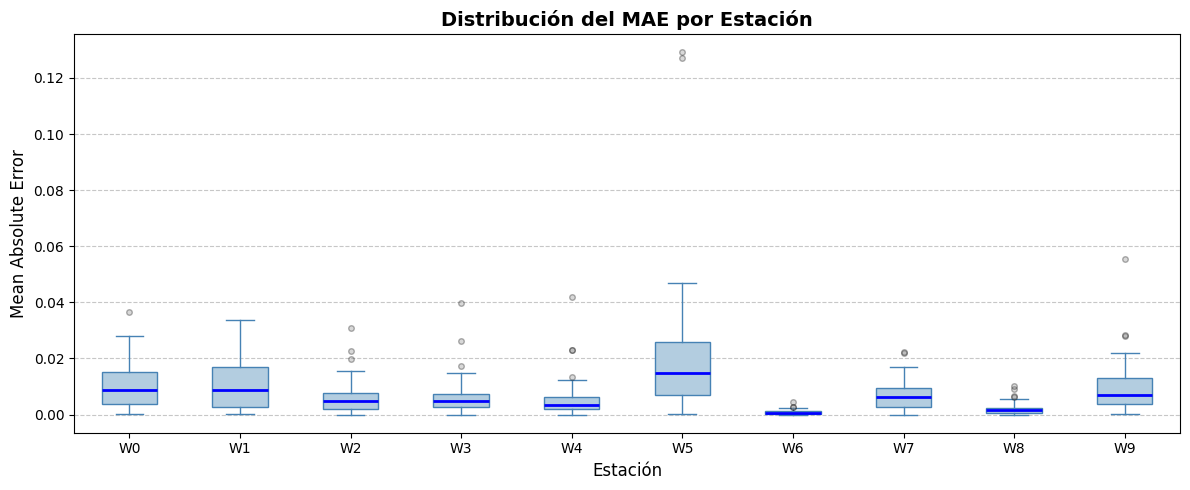

In [ ]:

y_pred_full = model.predict(X_test)
abs_errors = np.abs(y_test.values - y_pred_full)

plt.figure(figsize=(12, 5))

# Crear boxplot personalizado
box = plt.boxplot(
    abs_errors,
    patch_artist=True,  # Permite colorear las cajas
    labels=[f"W{i}" for i in range(10)],
    medianprops=dict(color='Blue', linewidth=2),  # Línea del percentil 50 (mediana)
    boxprops=dict(facecolor='#b3cde0', color='#4682b4'),  # Color de la caja
    whiskerprops=dict(color='#4682b4'),
    capprops=dict(color='#4682b4'),
    flierprops=dict(markerfacecolor='gray', marker='o', markersize=4, alpha=0.3)
)

# Opcional: personalizar cada caja (si querés usar colores distintos por estación)
# colors = plt.cm.viridis(np.linspace(0, 1, 10))
# for patch, color in zip(box['boxes'], colors):
#     patch.set_facecolor(color)

plt.title("Distribución del MAE por Estación", fontsize=14, fontweight='bold')
plt.ylabel("Mean Absolute Error", fontsize=12)
plt.xlabel("Estación", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


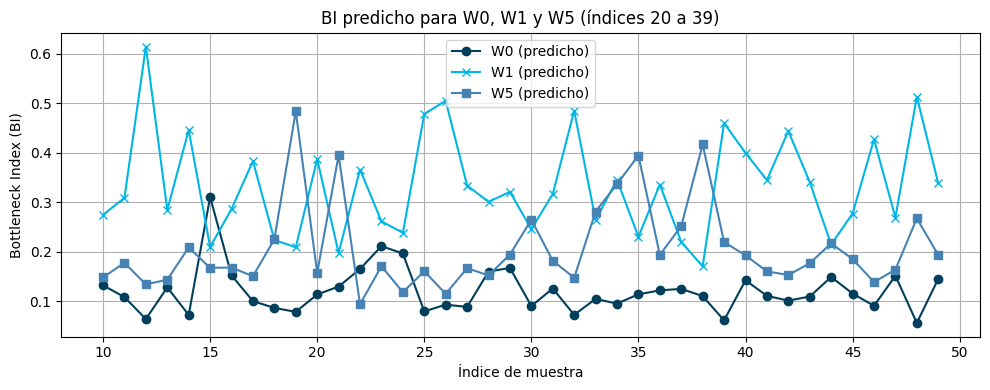

In [ ]:
y_pred = model.predict(X_test)

start, end = 10, 50
bi_w0 = y_pred[start:end, 0]
bi_w1 = y_pred[start:end, 1]
bi_w5 = y_pred[start:end, 5]

plt.figure(figsize=(10, 4))
plt.plot(range(start, end), bi_w0, label='W0 (predicho)', color='#003f5c', marker='o')
plt.plot(range(start, end), bi_w1, label='W1 (predicho)', color='#00b6e4', marker='x')
plt.plot(range(start, end), bi_w5, label='W5 (predicho)', color='#4682b4', marker='s')
plt.title("BI predicho para W0, W1 y W5 (índices 20 a 39)")
plt.xlabel("Índice de muestra")
plt.ylabel("Bottleneck Index (BI)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Bloque 7: Guardar modelo y scaler

In [ ]:
# Guardar modelo y scaler
best_model.save("modelo_BI.keras")
joblib.dump(scaler, "scaler_X.pkl")

['scaler_X.pkl']